# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [160]:
# Load pickled data
import pickle
import csv

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file='valid.p'
testing_file =  'test.p'
csv_file = 'signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(csv_file, mode='r') as f:
    signs = list(csv.reader(f))
    signs = signs[1:] # skip header
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Summary of datasets:")
print("--------------------")
print("Training shapes: Features - {}, Labels - {}".format(X_train.shape, y_train.shape))
print("Validation shapes: Features - {}, Labels - {}".format(X_valid.shape, y_valid.shape))
print("Test shapes: Features - {}, Labels - {}".format(X_test.shape, y_test.shape))

Summary of datasets:
--------------------
Training shapes: Features - (34799, 32, 32, 3), Labels - (34799,)
Validation shapes: Features - (4410, 32, 32, 3), Labels - (4410,)
Test shapes: Features - (12630, 32, 32, 3), Labels - (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [161]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of validation examples
n_valid = y_valid.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(signs)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [162]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Visualizations will be shown in the notebook.
%matplotlib inline

print("Training dataset size: {}".format(X_train.shape))

indices_train = np.random.randint(0, len(X_train), size=9)
indices_valid = np.random.randint(0, len(X_valid), size=9)
indices_test  = np.random.randint(0, len(X_test),  size=9)

Training dataset size: (34799, 32, 32, 3)


#### Helper functions

1. **gsnorm_image**: Return the normalized grayscale of an image
2. **augment_image**: Creates an augmented image by applying an affine transform at center of image
3. **display_image_grid**: Displays a 1x3:3x3 grid of example images from training, validation and test data sets

In [163]:
import random
import itertools
from textwrap import wrap
from skimage import color, exposure
from skimage.util import random_noise
import matplotlib.gridspec as gridspec
from skimage.transform import AffineTransform, warp

def gsnorm_image(image):
    image = color.rgb2gray(image)
    image = exposure.rescale_intensity(image, in_range='image', out_range=(0.0, 1.0))
    image = exposure.equalize_adapthist(image)
    return image

def augment_image(image):
    ty, tx = np.array(image.shape[:2]) / 2.
    tf_shift = AffineTransform(matrix=None, scale=None, rotation=None, shear=None, translation=(-tx, -ty))
    scx = random.uniform(1,1.05)
    scy = random.uniform(1,1.05)
    rot = random.uniform(-0.2,0.2)
    shr = random.uniform(-0.1,0.1)
    tf_affine = AffineTransform(matrix=None, scale=(scx, scy), rotation=rot, shear=shr, translation=None)
    tf_shift_inv = AffineTransform(matrix=None, scale=None, rotation=None, shear=None, translation=(tx, ty))
    image = warp(image, (tf_shift + (tf_affine + tf_shift_inv)).inverse)
    image = random_noise(image, mode='gaussian', mean=0, var=0.001)
    #image = random_noise(image, mode='s&p', amount=0.01, salt_vs_pepper=0.75)
    return image

def display_image_grid(itrain, ivalid, itest, normalize=False, augment=False):
    f = plt.figure(figsize=(20,7))
    f.suptitle("Training Dataset \t\t\t Validation Dataset \t\t\t Test Dataset".expandtabs(), fontsize=26)
    fgs = gridspec.GridSpec(1, 3)
    fgs.update(top=0.85,bottom=0.0)

    ssp = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=fgs[0])
    indices = itrain
    for rc, i in zip(itertools.product(range(3),range(3)),range(9)):
        a=plt.Subplot(f, ssp[rc[0], rc[1]])
        a.axis('off')
        a.set_title('\n'.join(wrap(signs[y_train[indices[i]]][1],15)))
        img = X_train[indices[i]]
        if normalize:
            img = gsnorm_image(img)
        if augment:
            img = augment_image(img)
        a.imshow(img, cmap='gray')
        f.add_subplot(a)

    ssp = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=fgs[1])
    indices = ivalid
    for rc, i in zip(itertools.product(range(3),range(3)),range(9)):
        a=plt.Subplot(f, ssp[rc[0], rc[1]])
        a.axis('off')
        a.set_title('\n'.join(wrap(signs[y_valid[indices[i]]][1],15)))
        img = X_valid[indices[i]]
        if normalize:
            img = gsnorm_image(img)
        if augment:
            img = augment_image(img)
        a.imshow(img, cmap='gray')
        f.add_subplot(a)

    ssp = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=fgs[2])
    indices = itest
    for rc, i in zip(itertools.product(range(3),range(3)),range(9)):
        a=plt.Subplot(f, ssp[rc[0], rc[1]])
        a.axis('off')
        a.set_title('\n'.join(wrap(signs[y_test[indices[i]]][1],15)))
        img = X_test[indices[i]]
        if normalize:
            img = gsnorm_image(img)
        if augment:
            img = augment_image(img)
        a.imshow(img, cmap='gray')
        f.add_subplot(a)

    plt.show()

#### Display random images selected from datasets in original form

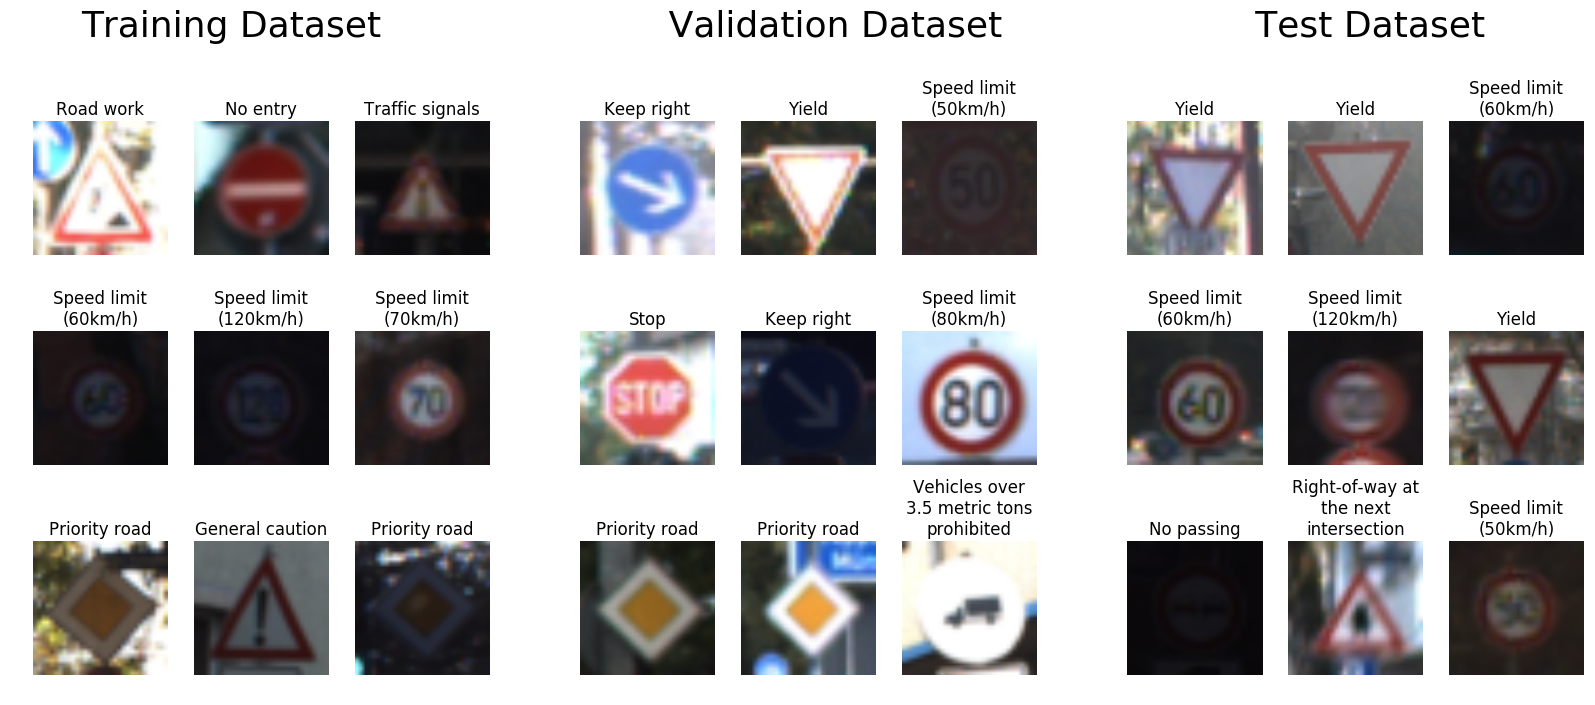

In [164]:
display_image_grid(indices_train, indices_valid, indices_test, normalize=False, augment=False)

**Note:** In the above set of images, the image brightness, contrast and clarity varies significantly. In the following, steps the normalized and augmented image set will be demonstrated.

#### Summary of class/label occurance in training, validation and test data sets

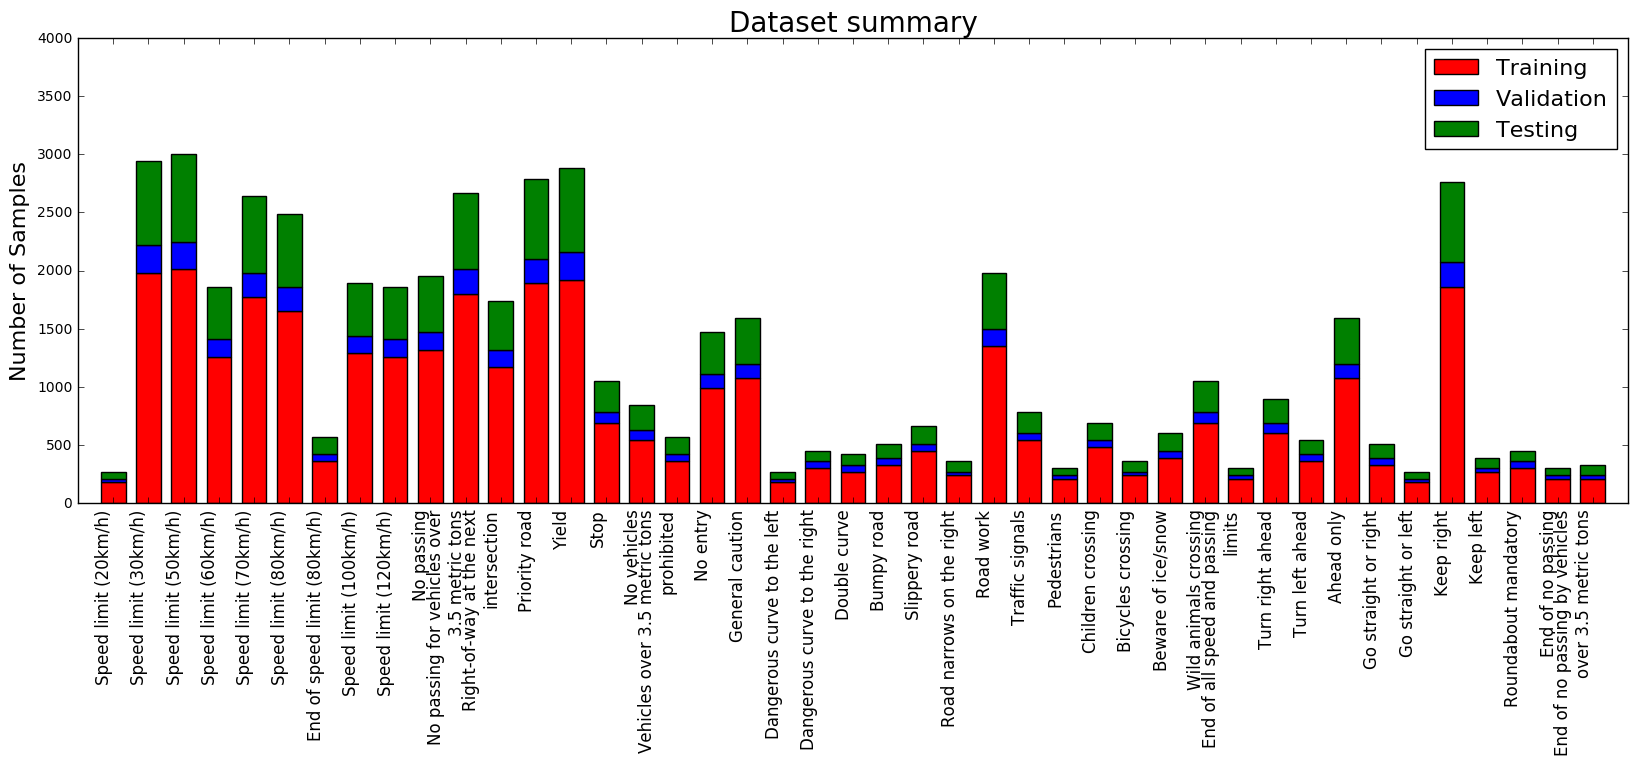

In [165]:
# histogram of label frequency
from textwrap import wrap

n_classes = 43
width = 0.7

labels = []
for s in signs:
    labels.append('\n'.join(wrap(s[1],30)))

h_train, b_train = np.histogram(y_train, bins=n_classes)
h_valid, b_valid = np.histogram(y_valid, bins=n_classes)
h_test,  b_test  = np.histogram(y_test,  bins=n_classes)

p1 = plt.bar(range(n_classes), h_train, width, color='red', align='center')
p2 = plt.bar(range(n_classes), h_valid, width, bottom=h_train, color='blue', align='center')
p3 = plt.bar(range(n_classes), h_test,  width, bottom=h_train+h_valid, color='green', align='center')

plt.ylabel('Number of Samples', fontsize=16)
plt.title('Dataset summary', fontsize=20)
plt.xticks(range(n_classes), labels, rotation='vertical', fontsize=12, ha='right')
plt.xlim(-1,43)
plt.yticks(np.arange(0, 4001, 500))
plt.legend((p1[0], p2[0], p3[0]), ('Training', 'Validation', 'Testing'), fontsize=16)

fig = plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [166]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

### Notes for review

First few iterations with direct implementation from LeNet-5 lab with color channels intact showed a maximum validation accuracy of about 89-90%. It was evident that this was a cieling without the use of grayscaling and normalization. As is demonstrated below, the benefit in accuracy due to grayscaling and normalization is another 7-8%. The final validation accuracy achieved was 97% with a testing accuracy of 100%.

#### Apply grayscale and normalization to example images from all three datasets

/home/carnd/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


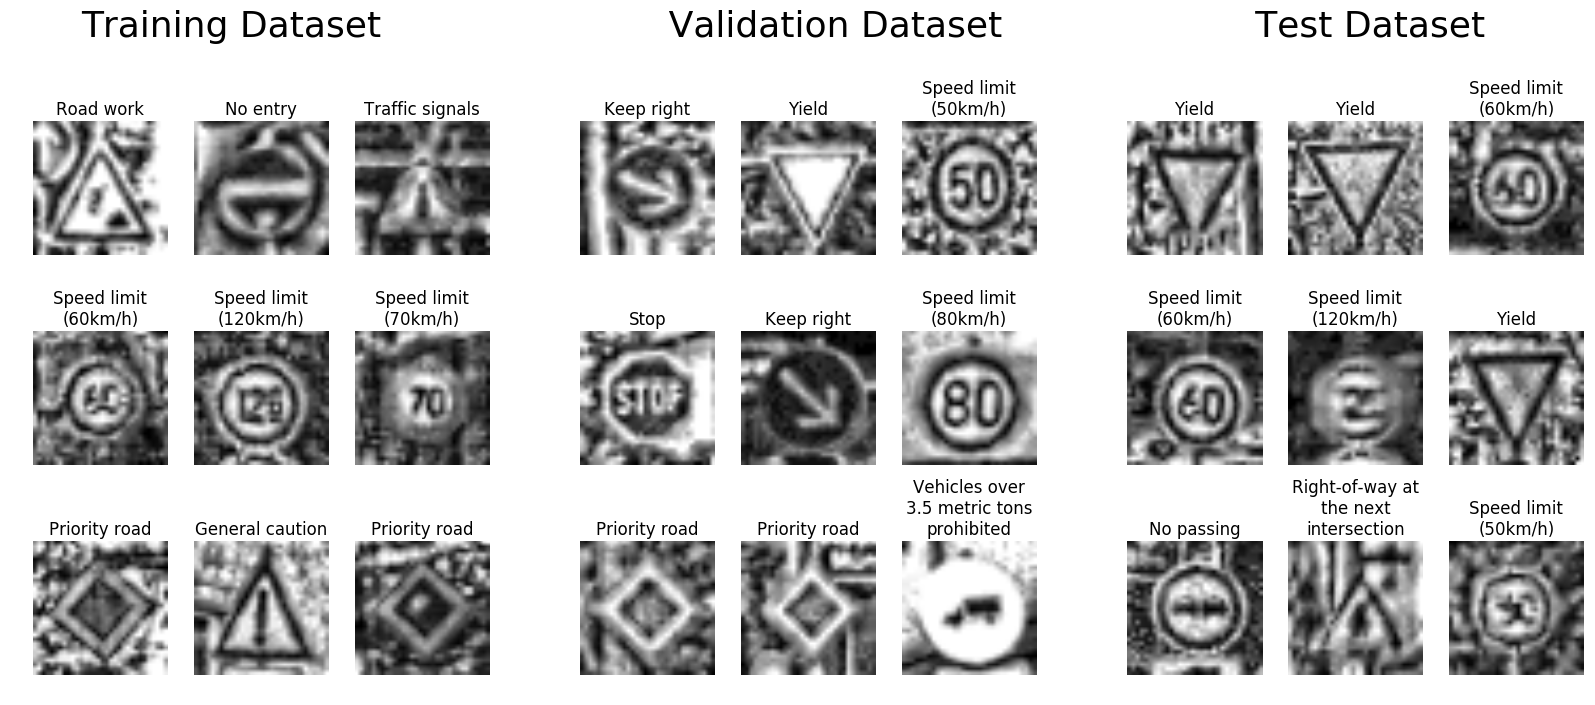

In [167]:
display_image_grid(indices_train, indices_valid, indices_test, normalize=True, augment=False)

#### Example of the augmentation performed on the images

The following images have been agumented for the purposes of expanding the training dataset. The details of the augmentation pipeline are presented in the *__augment\_image__* function. The function applies an affine transform (rotation, shear and scaling) with reference to the center fo the image.

Note that there are additional translational steps performed to ensure that the edges of the image are not biased with 0-pixels as a result of the affine transformations.

The image is subsequently also applied with Gaussian noise to simulate the influence of camera sensor noise and issues during the data acquisition process.

/home/carnd/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


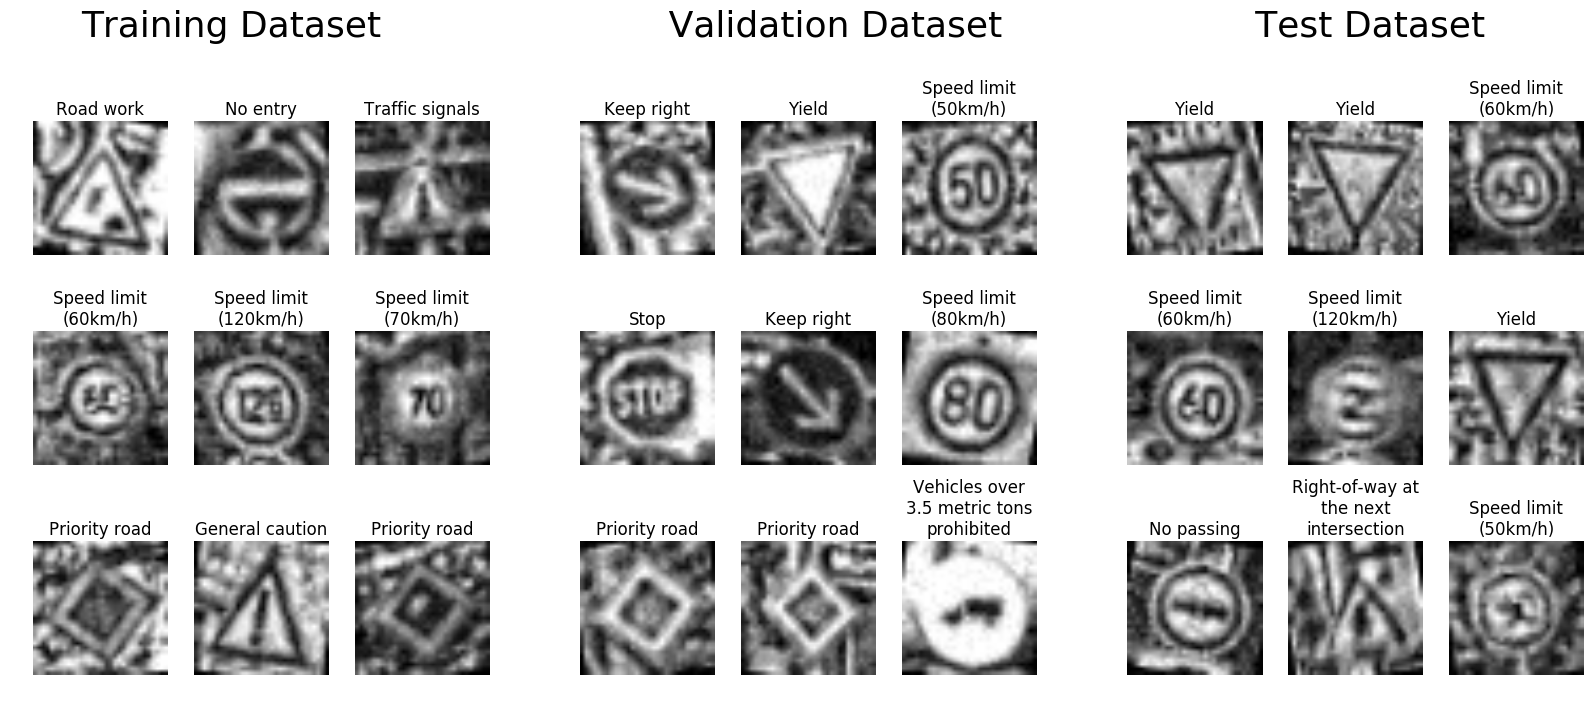

In [168]:
display_image_grid(indices_train, indices_valid, indices_test, normalize=True, augment=True)

#### Augment and Shuffle Training Data

Training data is shuffled before use. Also, correct the tensor shape for feeding into the network.

In [169]:
from os import path
from pickle import dump, load
from sklearn.utils import shuffle

if not path.exists("train_aug.p"):
    print("Generating data ...")
    X_train_aug = []
    y_train_aug = []
    for i in range(len(X_train)):
        tmp = gsnorm_image(X_train[i])
        # Add gray scale normalize image
        X_train_aug.append(tmp)
        y_train_aug.append(y_train[i])
        # Add augmented image
        X_train_aug.append(augment_image(tmp))
        y_train_aug.append(y_train[i])
    X_train_aug = np.float32(np.array(X_train_aug))
    X_train_aug = X_train_aug[:,:,:,np.newaxis]
    y_train_aug = np.array(y_train_aug)
    X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
    print("Saving data to pickle file ...")
    dump({"features": X_train_aug, "labels": y_train_aug}, open("train_aug.p", "wb"))
else:
    print("Found picked file. Loading data ...")
    train_aug = load(open("train_aug.p", mode='rb'))
    X_train_aug = train_aug['features']
    y_train_aug = train_aug['labels']

print("Augmented trainig dataset size: {}".format(X_train_aug.shape))

Found picked file. Loading data ...
Augmented trainig dataset size: (69598, 32, 32, 1)


#### Convert validation data to normalized grayscale (and save in a pickle file for later use)

The saving to pickle file significantly improve run-time and performance. Normalizing batch images on the fly added significant compute cost to the training / validation process.

In [170]:
if not path.exists("valid_gn.p"):
    print("Generating data ...")
    X_valid_gn = []
    for xd in X_valid:
        X_valid_gn.append(gsnorm_image(xd))
    X_valid_gn = np.float32(np.array(X_valid_gn))
    X_valid_gn = X_valid_gn[:,:,:,np.newaxis]
    print("Saving data to pickle file ...")
    dump({"features": X_valid_gn, "labels": y_valid}, open("valid_gn.p", "wb"))
else:
    print("Found picked file. Loading data ...")
    valid_gn = load(open("valid_gn.p", mode='rb'))
    X_valid_gn = valid_gn['features']
    y_valid = valid_gn['labels']

print("Normalized grayscale validation dataset size: {}".format(X_valid_gn.shape))

Found picked file. Loading data ...
Normalized grayscale validation dataset size: (4410, 32, 32, 1)


#### Convert test data to normalized grayscale (and save in a pickle file for later use)

The saving to pickle file significantly improve run-time and performance. Normalizing batch images on the fly added significant compute cost to the training / validation process.

In [171]:
if not path.exists("test_gn.p"):
    print("Generating data ...")
    X_test_gn = []
    for xd in X_test:
        X_test_gn.append(gsnorm_image(xd))
    X_test_gn = np.float32(np.array(X_test_gn))
    X_test_gn = X_test_gn[:,:,:,np.newaxis]
    print("Saving data to pickle file ...")
    dump({"features": X_test_gn, "labels": y_test}, open("test_gn.p", "wb"))
else:
    print("Found picked file. Loading data ...")
    test_gn = load(open("test_gn.p", mode='rb'))
    X_test_gn = test_gn['features']
    y_test = test_gn['labels']

print("Normalized grayscale validation dataset size: {}".format(X_test_gn.shape))

Found picked file. Loading data ...
Normalized grayscale validation dataset size: (12630, 32, 32, 1)


#### Tensorflow Setup

Placeholder to define EPOCH and BATCH_SIZE values

In [172]:
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 128

### Model Architecture

In [173]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

#### Implementation of the LeNet-5 Architecture
Implementation is based on the LeNet Lab code based on [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

##### Input
Since the traffic signs are color data, the LeNet architecture image input dimension are changed to 32x32x3.

##### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 43 outputs.

##### Output
Return the result of the 2nd fully connected layer.

In [174]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    weights = {
    'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean=mu, stddev=sigma, dtype=tf.float32)),
    'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma, dtype=tf.float32)),
    'wd1': tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma, dtype=tf.float32)),
    'wd2': tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma, dtype=tf.float32)),
    'out': tf.Variable(tf.truncated_normal([84, 43]))}

    biases = {
    'bc1': tf.Variable(tf.zeros([6])),
    'bc2': tf.Variable(tf.zeros([16])),
    'bd1': tf.Variable(tf.zeros([120])),
    'bd2': tf.Variable(tf.zeros([84])),
    'out': tf.Variable(tf.zeros([43]))}
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    xc1 = tf.nn.bias_add(tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding='VALID'), biases['bc1'])
    # TODO: Activation.
    xc1 = tf.nn.relu(xc1)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    yc1 = tf.nn.max_pool(xc1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #print(yc1.get_shape())

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    xc2 = tf.nn.bias_add(tf.nn.conv2d(yc1, weights['wc2'], strides=[1, 1, 1, 1], padding='VALID'), biases['bc2'])
    # TODO: Activation.
    xc2 = tf.nn.relu(xc2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    yc2 = tf.nn.max_pool(xc2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #print(yc2.get_shape())

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    flt = flatten(yc2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(flt, weights['wd1']), biases['bd1'])
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    #fc1 = tf.nn.dropout(fc1, dropout)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    #fc1 = tf.nn.dropout(fc1, dropout)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return logits, yc1

#### Features and Labels

x -> input images & y -> output labels

In [175]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

#### Training Pipeline

In [176]:
rate = 0.0005

logits, plotvar = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#### Model Evaluation (Loss and Accuracy)

In [177]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0 ; total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        [accuracy, loss] = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return [total_accuracy / num_examples, total_loss / num_examples]

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [178]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

#### Train the Model

Run training data through pipeline after shuffling at each epoch.

Measure the loss and accuracy of the validation set and save model.

The implementation is slightly modified so as to save the model with best accuracy. During trials, it was observed that the last epoch does not necessarily give the best validation accuracy. A simple book keeping mechanism is used to store the model when the best accuracy level is observed during epoch traversal.

In [179]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_aug)
    
    print("Training...")
    print()
    t_hist_cnt = 0 ; t_hist_acc = [] ; t_hist_best_acc = [] ;  t_hist_loss = []
    v_hist_cnt = 0 ; v_hist_acc = [] ; v_hist_best_acc = [] ;  v_hist_loss = [] ; v_best_acc = 0 
    for i in range(EPOCHS):
        X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_aug[offset:end], y_train_aug[offset:end]
            [t_opn, t_acc, t_loss] = sess.run([training_operation, accuracy_operation, loss_operation],
                                           feed_dict={x: batch_x, y: batch_y})
        t_hist_acc.append([i, t_acc]) ; t_hist_loss.append([i, t_loss])
        if not t_hist_best_acc:
            t_hist_best_acc.append([i, t_acc])
        if t_acc > max([l[1] for l in t_hist_best_acc]):
            t_hist_best_acc.append([i, t_acc])
        [v_acc, v_loss] = evaluate(X_valid_gn, y_valid)
        v_hist_acc.append([i, v_acc]) ; v_hist_loss.append([i, v_loss])
        if not v_hist_best_acc:
            v_best_acc = v_acc
            v_hist_best_acc.append([i, v_acc])
        if v_acc > max([l[1] for l in v_hist_best_acc]):
            saver.save(sess, './lenet')
            v_best_acc = v_acc
            v_hist_best_acc.append([i, v_acc])
        print("EPOCH: {:02d}, CURR_VACC: {:.3f}, BEST_VACC: {:.3f}".format(i, v_acc, v_best_acc))
    print("Done training!")

print("\n\n")
print("Best test accuracy: {:.3f}".format(v_best_acc))

Training...

EPOCH: 00, CURR_VACC: 0.811, BEST_VACC: 0.811
EPOCH: 01, CURR_VACC: 0.901, BEST_VACC: 0.901
EPOCH: 02, CURR_VACC: 0.918, BEST_VACC: 0.918
EPOCH: 03, CURR_VACC: 0.932, BEST_VACC: 0.932
EPOCH: 04, CURR_VACC: 0.932, BEST_VACC: 0.932
EPOCH: 05, CURR_VACC: 0.941, BEST_VACC: 0.941
EPOCH: 06, CURR_VACC: 0.947, BEST_VACC: 0.947
EPOCH: 07, CURR_VACC: 0.949, BEST_VACC: 0.949
EPOCH: 08, CURR_VACC: 0.947, BEST_VACC: 0.949
EPOCH: 09, CURR_VACC: 0.949, BEST_VACC: 0.949
EPOCH: 10, CURR_VACC: 0.947, BEST_VACC: 0.949
EPOCH: 11, CURR_VACC: 0.949, BEST_VACC: 0.949
EPOCH: 12, CURR_VACC: 0.944, BEST_VACC: 0.949
EPOCH: 13, CURR_VACC: 0.957, BEST_VACC: 0.957
EPOCH: 14, CURR_VACC: 0.956, BEST_VACC: 0.957
EPOCH: 15, CURR_VACC: 0.954, BEST_VACC: 0.957
EPOCH: 16, CURR_VACC: 0.952, BEST_VACC: 0.957
EPOCH: 17, CURR_VACC: 0.952, BEST_VACC: 0.957
EPOCH: 18, CURR_VACC: 0.955, BEST_VACC: 0.957
EPOCH: 19, CURR_VACC: 0.963, BEST_VACC: 0.963
EPOCH: 20, CURR_VACC: 0.955, BEST_VACC: 0.963
EPOCH: 21, CURR_VACC:

#### History plots for training / validation accuracy and loss

(-0.1, 1.1)

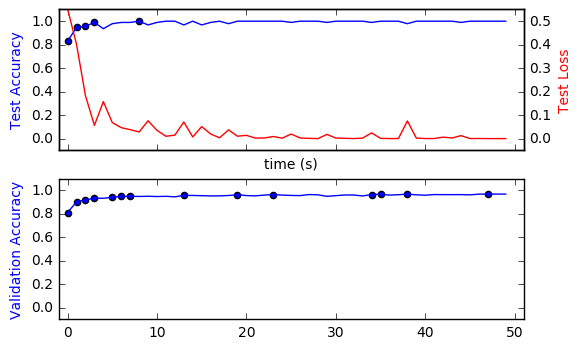

In [183]:
f, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.set_xlabel('time (s)')
ax1.plot([l[0] for l in t_hist_acc], [l[1] for l in t_hist_acc], 'b')
ax1.scatter([l[0] for l in t_hist_best_acc], [l[1] for l in t_hist_best_acc])
ax1.set_ylabel('Test Accuracy', color='b')
ax1.set_xlim([-1,EPOCHS+1])
ax1.set_ylim([-0.1,1.1])

ax12 = ax1.twinx()
ax12.set_ylabel('Test Loss', color='r')
ax12.plot([l[0] for l in t_hist_loss], [l[1] for l in t_hist_loss], 'r')
ax12.set_xlim([-1,EPOCHS])
ax12.set_ylim([-0.05,0.55])

ax2.plot([l[0] for l in v_hist_acc], [l[1] for l in v_hist_acc], 'b')
ax2.scatter([l[0] for l in v_hist_best_acc], [l[1] for l in v_hist_best_acc])
ax2.set_ylabel('Validation Accuracy', color='b')
ax2.set_xlim([-1,EPOCHS+1])
ax2.set_ylim([-0.1,1.1])

## Student Notes on Step 2:

Some of the key observation for step 2 are as follows:

1. The LeNet-5 network architecture was found satisfactory for the purpose of traffic sign classification.

2. Image dataset augmentation by including grayscaled, normalized and affine transformed variants improved accuracy significantly.

3. The training accuracy saturated quickly to 100% within 10 epochs, while the test loss stabilized to low values by 25-30 epochs.

4. The validation accuracy also saturated within 10 epochs to a very respectable 97%.

5. Overall, with LeNet-5, the accuracy is pretty close typical benchmarks. Further improves upto 99.65% are possible.

Notes for further improvement of the performance (>97%) are as follows:

1. Additional steps such as flipping / mirroring can also improve accuracy. However, care has to be taken here not to apply such tranformations to images where there are no folds of symmetry.

2. The following architectues are promising and can be explored to further improve accuracy.

    a. [Sermanet-LeCun](http://yann.lecun.org/exdb/publis/psgz/sermanet-ijcnn-11.ps.gz)
    
    b. [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
    
    c. [VGGNet](https://arxiv.org/pdf/1409.1556.pdf)
    
    d. [NVIDIA CNN](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/)
    
    e. [HLTCNN](http://ieeexplore.ieee.org/document/6766231/)

3. Implementaiton of drop-out can show some more improvement. More discussion can be found [here](publications.lib.chalmers.se/records/fulltext/238914/238914.pdf). I hope to return and improve this project over the course of the next few months.

#### Step 3a: Try Out the Model on Test Images

#### Load and Output the Images

The images are directly pulled out of the test data set obtained as a part of the course material. Here, 48 random images are chosen to assess the quality of predictions using Accuracy, Recall, Precision, F-Score, Support metrics. Also, the confusion matrix is presented for visual respresentation.

/home/carnd/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


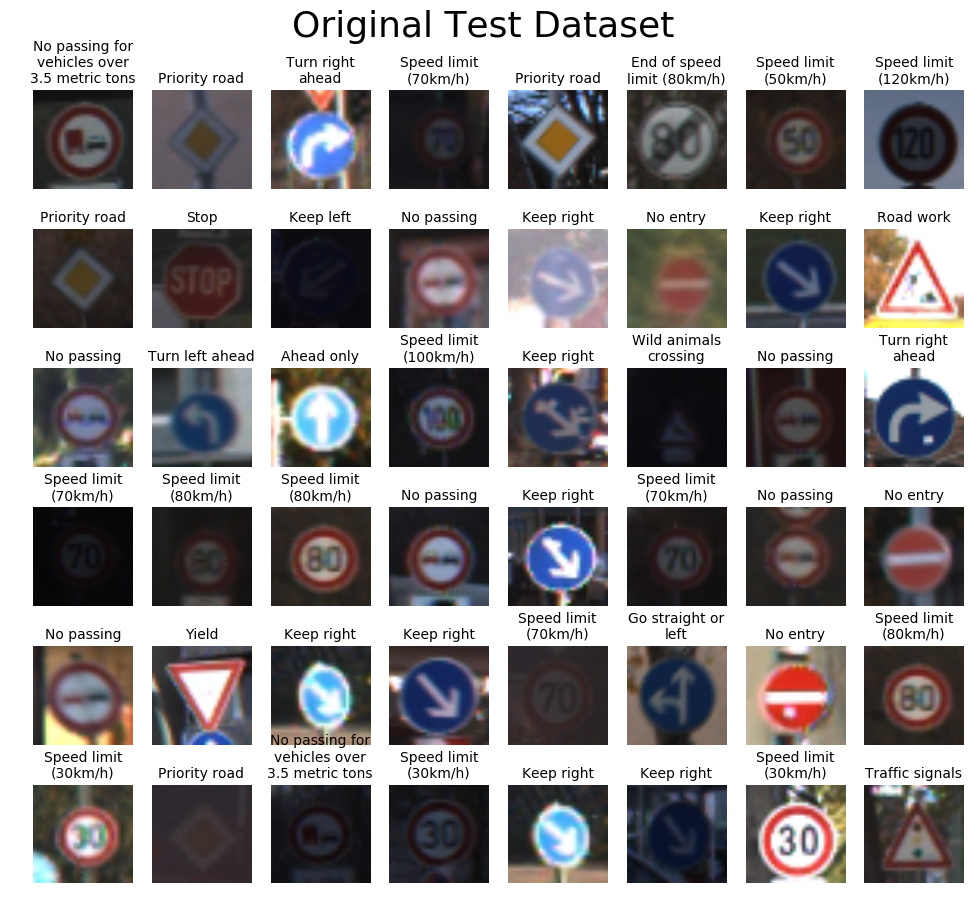

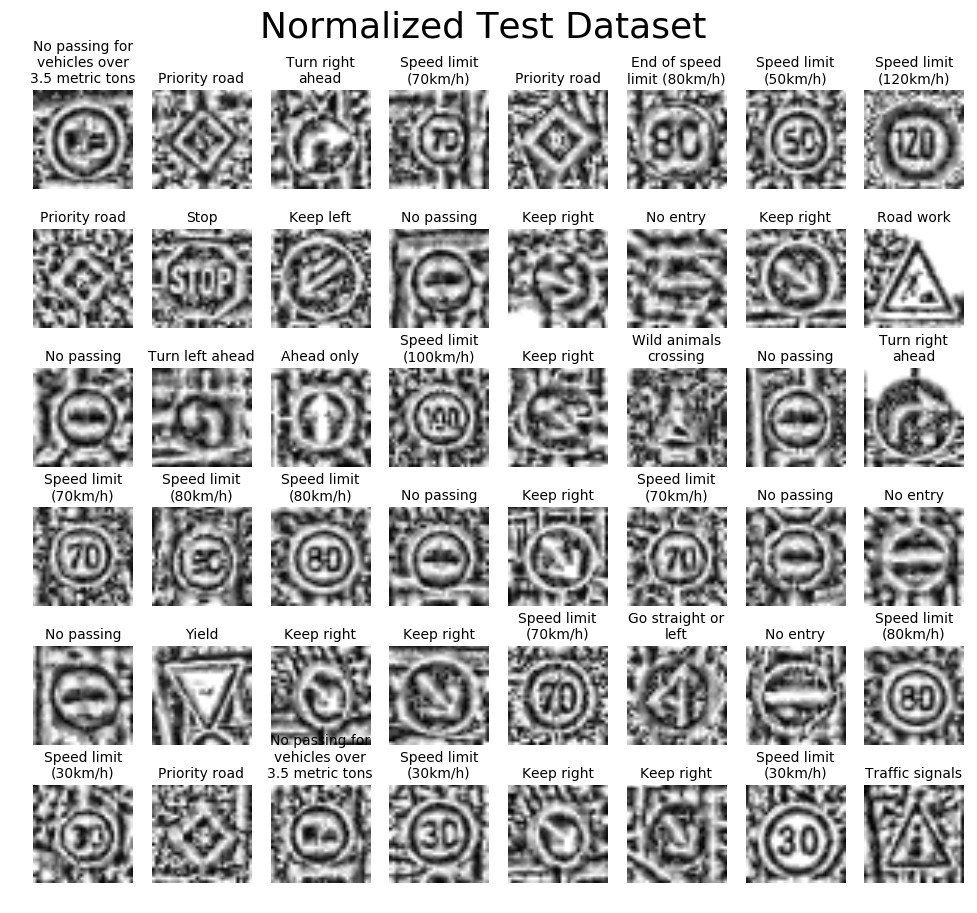

In [219]:
nrow = 6 ; ncol = 8

indices = np.random.randint(0, len(X_test_gn), size=nrow*ncols)

X_pset = X_test[indices]
y_pset = y_test[indices]

f = plt.figure(figsize=(int(ncol*1.5),int(nrow*1.5)))
f.suptitle("Original Test Dataset", fontsize=26)
fgs = gridspec.GridSpec(nrow, ncol)
fgs.update(top=0.9,bottom=0.0)
for rc, i in zip(itertools.product(range(nrow),range(ncol)),range(nrow*ncol)):
    a=plt.Subplot(f, fgs[rc[0], rc[1]])
    a.axis('off')
    a.set_title('\n'.join(wrap(signs[y_pset[i]][1],15)), fontsize=10)
    a.imshow(X_pset[i])
    f.add_subplot(a)

X_pset = X_test_gn[indices]
y_pset = y_test[indices]

f = plt.figure(figsize=(int(ncol*1.5),int(nrow*1.5)))
f.suptitle("Normalized Test Dataset", fontsize=26)
fgs = gridspec.GridSpec(nrow, ncol)
fgs.update(top=0.9,bottom=0.0)
for rc, i in zip(itertools.product(range(nrow),range(ncol)),range(nrow*ncol)):
    a=plt.Subplot(f, fgs[rc[0], rc[1]])
    a.axis('off')
    a.set_title('\n'.join(wrap(signs[y_pset[i]][1],15)), fontsize=10)
    a.imshow(gsnorm_image(X_pset[i].squeeze()), cmap='gray')
    f.add_subplot(a)

### Predict the Sign Type for Each Image

In [220]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [221]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

#### Get the test set based on indices extracted in previous step and test

The validation accuracy obtained during the training operation is 97%.

The trained model is able to identify the 48 test images with 100% accuracy.

Test Accuracy: 1.000
Precision : [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]
Recall    : [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]
F-score   : [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]
Support   : [3 1 4 3 1 1 1 6 2 4 1 1 3 1 1 1 2 1 1 1 8 1]


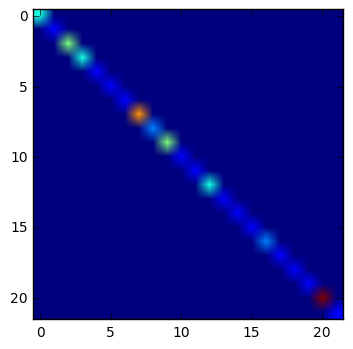

In [222]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

saver = tf.train.Saver()
preds = tf.argmax(logits, 1)
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    [test_acc, test_preds] = sess.run(
        [accuracy_operation, preds],
        feed_dict={x: X_pset, y: y_pset})

print("Test Accuracy: {:.3f}".format(test_acc))
#y_pset_labels = [signs[l][1] for l in y_pset]
#test_preds_labels = [signs[l][1] for l in test_preds]
#prfs = precision_recall_fscore_support(y_pset_labels, test_preds_labels)
prfs = precision_recall_fscore_support(y_pset, test_preds)
print("Precision :", prfs[0])
print("Recall    :", prfs[1])
print("F-score   :", prfs[2])
print("Support   :", prfs[3])
f = plt.imshow(confusion_matrix(y_pset, test_preds))

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [224]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

## NOTE:

Images were obtained using an academic database post presented on [Medium](https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.ni141p60k). Direct link the image tile is [here](https://cdn-images-1.medium.com/max/800/1*JqMjJ2u-9Blnzh0dEYbiRw.png). This is based on the Belgian traffic sign database. 28 images were selected from this list and processed.

<img src="./images/1-JqMjJ2u-9Blnzh0dEYbiRw.png">

In [245]:
import os
from skimage.io import imread
test_images = np.empty([0, 32, 32, 3], dtype = np.int32)
for i in range(1,29):
    file_name = 'images/' + str(i) + '.png'
    if os.path.isfile(file_name):
        print("Reading file: {}".format(file_name))
    else:
        continue
    image = imread(file_name)
    test_images = np.append(test_images, [image[:, :, :3]], axis = 0)
print("Test image dataset size: {}".format(test_images.shape))

Reading file: images/1.png
Reading file: images/2.png
Reading file: images/3.png
Reading file: images/4.png
Reading file: images/5.png
Reading file: images/6.png
Reading file: images/7.png
Reading file: images/8.png
Reading file: images/9.png
Reading file: images/10.png
Reading file: images/11.png
Reading file: images/12.png
Reading file: images/13.png
Reading file: images/14.png
Reading file: images/15.png
Reading file: images/16.png
Reading file: images/17.png
Reading file: images/18.png
Reading file: images/19.png
Reading file: images/20.png
Reading file: images/21.png
Reading file: images/22.png
Reading file: images/23.png
Reading file: images/24.png
Reading file: images/25.png
Reading file: images/26.png
Reading file: images/27.png
Reading file: images/28.png
Test image dataset size: (28, 32, 32, 3)


#### Convert files to normalized grayscale

In [246]:
if not path.exists("final_test_gn.p"):
    print("Generating data ...")
    test_images_gn = []
    for xd in test_images:
        test_images_gn.append(gsnorm_image(xd))
    test_images_gn = np.float32(np.array(test_images_gn))
    test_images_gn = test_images_gn[:,:,:,np.newaxis]
    print("Saving data to pickle file ...")
    dump({"features": test_images_gn}, open("test_images_gn.p", "wb"))
else:
    print("Found picked file. Loading data ...")
    test_images_gn = load(open("test_images_gn.p", mode='rb'))
    test_images_gn = test_gn['features']

print("Normalized grayscale final test dataset size: {}".format(test_images_gn.shape))

Generating data ...


/home/carnd/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


Saving data to pickle file ...
Normalized grayscale final test dataset size: (28, 32, 32, 1)


#### Display image data

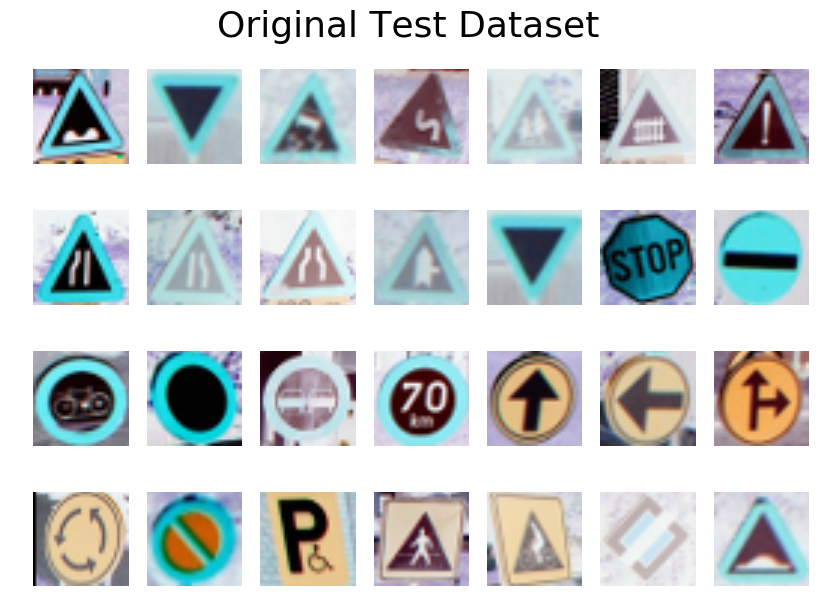

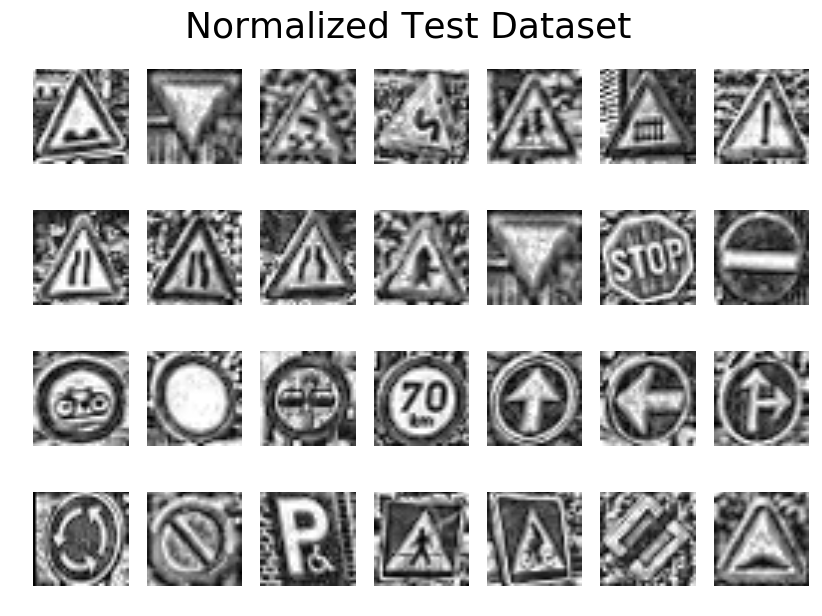

In [256]:
nrow = 4 ; ncol = 7

f = plt.figure(figsize=(int(ncol*1.5),int(nrow*1.5)))
f.suptitle("Original Test Dataset", fontsize=26)
fgs = gridspec.GridSpec(nrow, ncol)
fgs.update(top=0.9,bottom=0.0)
for rc, i in zip(itertools.product(range(nrow),range(ncol)),range(nrow*ncol)):
    a=plt.Subplot(f, fgs[rc[0], rc[1]])
    a.axis('off')
    a.imshow(test_images[i])
    f.add_subplot(a)

f = plt.figure(figsize=(int(ncol*1.5),int(nrow*1.5)))
f.suptitle("Normalized Test Dataset", fontsize=26)
fgs = gridspec.GridSpec(nrow, ncol)
fgs.update(top=0.9,bottom=0.0)
for rc, i in zip(itertools.product(range(nrow),range(ncol)),range(nrow*ncol)):
    a=plt.Subplot(f, fgs[rc[0], rc[1]])
    a.axis('off')
    a.imshow(test_images_gn[i].squeeze(), cmap='gray')
    f.add_subplot(a)

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [257]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In the following, the first of the top five softmax probabilities correctly identifies the traffic sign image with a probability of 1.0. This means that the model is performing very nicely.

In [273]:
saver = tf.train.Saver()
sfmax = tf.nn.top_k(tf.nn.softmax(logits), k=5)
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    sm = sess.run(sfmax, feed_dict={x: test_images_gn})
print(sm)

TopKV2(values=array([[  1.00000000e+00,   3.07388525e-18,   8.39606882e-19,
          2.84345248e-19,   6.02804188e-20],
       [  1.00000000e+00,   2.20934694e-13,   2.40330030e-14,
          2.30417661e-17,   1.00235530e-17],
       [  7.89848328e-01,   2.10066423e-01,   8.10377605e-05,
          2.11222596e-06,   2.01798889e-06],
       [  9.77845967e-01,   2.04561949e-02,   1.58662617e-03,
          7.91948551e-05,   2.81402390e-05],
       [  9.99437153e-01,   5.62826870e-04,   2.98480601e-10,
          5.26436707e-11,   3.32594959e-11],
       [  8.82136643e-01,   1.17534228e-01,   1.68863698e-04,
          1.56417693e-04,   3.79987159e-06],
       [  9.99999523e-01,   4.75067822e-07,   6.18521234e-09,
          6.84370005e-10,   6.12990436e-10],
       [  5.27435303e-01,   4.02481467e-01,   6.77985698e-02,
          1.90735504e-03,   3.51784664e-04],
       [  1.00000000e+00,   5.23530872e-08,   3.20722151e-08,
          7.77533060e-09,   1.75051329e-09],
       [  5.92887521e-0

#### Plot the results

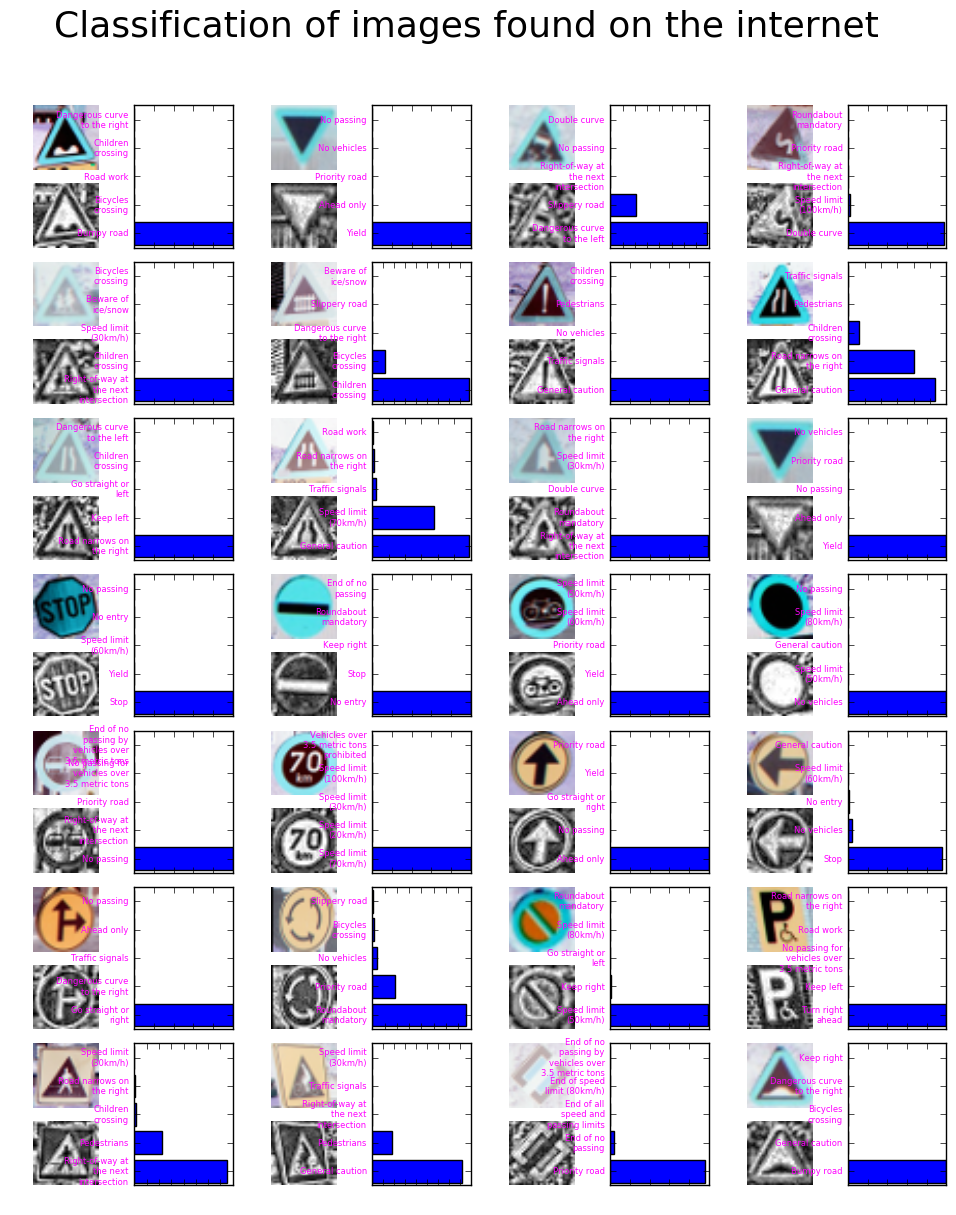

In [348]:
nrow = 7 ; ncol = 4
f = plt.figure(figsize=(int(3*ncol),int(1.8*nrow)))

f.suptitle("Classification of images found on the internet", fontsize=26)
fgs = gridspec.GridSpec(nrow, ncol, wspace=0.1, hspace=0.1)
fgs.update(top=0.9,bottom=0.0)

for rc, i in zip(itertools.product(range(nrow),range(ncol)),range(nrow*ncol)):
    
    ssp = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=fgs[rc[0],rc[1]])
    
    a=plt.Subplot(f, ssp[0, 0]) ; a.axis('off')
    a.imshow(test_images[i]) ; f.add_subplot(a)
    
    a=plt.Subplot(f, ssp[1, 0]) ; a.axis('off')
    a.imshow(test_images_gn[i].squeeze(), cmap='gray') ; f.add_subplot(a)
    
    a=plt.Subplot(f, ssp[:, 1])
    a.barh(np.arange(5)+0.5, sm.values[i], align='center')
    a.set_yticks(np.arange(5)+0.5)
    ylbls = []
    for l in sm.indices[i]:
        ylbls.append('\n'.join(wrap(signs[l][1],15)))
    a.xaxis.set_ticklabels([], fontsize=6)
    a.yaxis.set_ticklabels(ylbls, fontsize=6, color='magenta')
    f.add_subplot(a)

## Discussion on the test with images obtained from internet

The trained network did a decent job with the images obtained from the internet. Since these images are from the Belgian database, there are a few images that were not a part of the training test from the German traffic sign database. The network is able to determine 20 out of 28 images correctly (accuracy ~ 72%). Out of the wrongly identified 8 images, 3 were never presented during the training process (railway cross, cyclists, handicap parking). So, overall the accuracy could be considered 83%, which is pretty decent for images from unrelated dataset.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [306]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : [image_input]})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

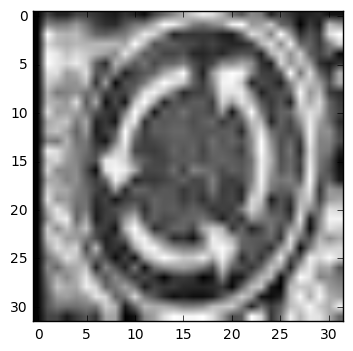

In [337]:
plt.imshow(X_pset[18].squeeze(), cmap='gray')

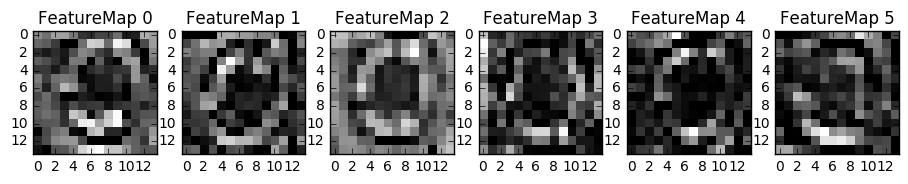

In [338]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    outputFeatureMap(X_pset[18], plotvar, activation_min=-1, activation_max=-1 ,plt_num=1)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

The image chosen for the visualization of the features maps in outputs at intermediate layers was the mandatry roundabout sign. The output at this particular layer is 14x14x6 due to convolution, ReLU and max-pooling. At this layer, the high level features for curves/shapes of the border and arrows have been properly captured. The network is able to clearly identify these high level features and related to traffic sign. The curved features pertaining to the circular border, arrow heads and the curved arrow lines have been properly represented. This indicates that the network is looking at these interesting characteristics.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 